# Estimators

State estimation solves the partial observability portion of the POMDP, i.e. when the system state $x$ is not directly measurable, but a set of noisy measurements $y$ gives insight to the state.  This estimation is useful when a mapping from $y \rightarrow x$ is not easy to develop.  Sia uses a two-step Recursive Bayesian procedure to perform this estimation.

1. In the **prediction** step, the dynamics model $p(x_{k+1} | x_k, u_k)$ is used to propogate the belief in the state given its previous belief and the action that was applied.  This typically increases the uncertainty as noise is integrated through the system.  The propogation is performed by

$$
p(x_{k+1} | u_k) = \int p(x_{k+1} | x_k, u_k) p(x_k) dx_k
$$

2. In the **correction** step, the measurement model $p(y | x)$ is used to update the belief in the state using the belief from prediction as a prior.  It reduces the uncertainty in the state as it focuses the belief on a specific portion of the measurement.  This update is performed via Bayes' rule

$$
p(x_k) \propto p(y_k | x_k) p(x_k | u_{k-1})
$$

In Sia, Bayesian estimators inherit from the virtual base class `sia.Estimator` which provides methods for both `predict()` and `correct()`.  The `estimate()` method is just a convenience method that runs predict then correct.  Sia includes several estimators, outlined in the table below.  Note that models in parenthesis are implicitly supported due to model inheritance. Also note that both discrete time and continuous time model variants are supported.

| Estimator            | Optimal     | Supported dynamics and measurement models                                         |
| -------------------- | ----------- | --------------------------------------------------------------------------------  |
| KF         | Yes         | LinearGaussian                                                                    |
| EKF | No          | Linearizable (NonlinearGaussian, LinearGaussian)                                  |
| PF       | No          | DynamicsModel, MeasurementModel (Linearizable, NonlinearGaussian, LinearGaussian) |

**References**

1. [S. Thrun, W. Burard, and D. Fox, Probabilistic Robotics, MIT Press, 2004.](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)

2. [J. L. Crassidis and J. L. Junkins, Optimal Estimation of Dynamic Systems, 2nd Ed., CRC Press, 2004.](http://ancs.eng.buffalo.edu/index.php/Optimal_Estimation_of_Dynamic_Systems_2nd_Edition)

3. [M. S. Arulampalam et. al., A Tutorial on Particle Filters for Online Nonlinear/Non-Gaussian Bayesian Tracking, IEEE Transactions on Signal Processing, 2002.](http://www.dcsc.tudelft.nl/~sc4081/2018/assign/pap/andrea_PFR_paper.pdf)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(10)

**Example**

To illustrate use of the estimators, we use an example from Crassidis and Junkins 2012, pp. 165, example 3.3.  The filter estimates flight attitude rate and bias error.  The state $x$ = (attitude, rate bias error), the input $u$ = (measured attitude rate), and the output is $y$ = (measured attitude).  The linear system is 

$$
x_k = \begin{pmatrix} 1 & -\Delta t \\ \Delta t & 0 \end{pmatrix} x_{k-1} 
 + \begin{pmatrix} \Delta t \\ 0 \end{pmatrix} u_k 
 + w_k \\
y_k = \begin{pmatrix} 1 & 0 \end{pmatrix} x_k + v_k
$$

where $w_k \sim \mathcal{N}(0,Q)$ is process noise and $v_k \sim \mathcal{R}(0,R)$ is measurement noise, both determined via spectral power densities of the continuous time measurement.

In [2]:
dt = 1
sn = 17E-4
su = np.sqrt(10)*1E-10
sv = np.sqrt(10)*1E-7
q00 = sv**2 * dt + su**2 * dt**3 / 3
q01 = - su**2 * dt**2 / 2
q11 = su**2 * dt
r = sn**2

dynamics = sia.LinearGaussianDynamics(
    F=np.array([[1, -dt], [0, 1]]),
    G=np.array([[dt], [0]]),
    Q=np.array([[q00, q01], [q01, q11]]))
measurement = sia.LinearGaussianMeasurement(
    H=np.array([[1, 0]]),
    R=np.array([[r]]))

## Kalman Filter (KF)

The Kalman filter is optimal for a linear Gaussian system.  It has no tuning parameters other than the model covariances themselves.  It is initialized by a `sia.Gaussian` prior $\mathcal{N}(x_0, P_0)$.

1. The prediction step propogates the state and Gaussian covariance through the linear system dynamics.

\begin{gather}
x_{k+1} = F x_k + G u_k \\
P_{k+1} = F P_k F^\top + Q
\end{gather}

2. The correction step computes the optimal Kalman gain and updates the state and covariance based on the measurement.

\begin{gather}
K_k = P_k H^\top \left( H P_k H^\top + R \right)^{-1} \\
x_k = x_k + K_k \left( y_k - H x_k \right) \\
P_k = \left(I - K_k H \right) P_k
\end{gather}

The belief in the state is then $p(x) =\mathcal{N}(x_k, P_k)$.

**Tuning.** In practice, the Kalman filter is tuned by adjusting the model noise covariance parameters $Q$ and $R$.  A higher $Q$ results in the estimator trusting the dynamics model less, while a higher $R$ results in the estimator trusting the measurement model less.  Typically, $Q$ and $R$ are estimated from data and then inflated by scalar factors $\alpha, \beta$, i.e. $Q = \alpha Q_{data}$, $R = \beta R_{data}$.

In [3]:
# Initialize the Kalman filter
prior = sia.Gaussian(mean=np.array([0, 0]), covariance=np.diag([1E-4, 1E-12]))
kf = sia.KF(dynamics, measurement, state=prior)

## Extended Kalman Filter (EKF)

The EKF is a suboptimal filter that applies the KF assumptions to a local linearization of the dynamics and measurement.  It is good for well-behaved functions, meaning ones where the linearization is a good approximation of the local dynamics within the region of uncertainty.  Problems arise when the uncertainty is warped in such a way that it is no longer Gaussian and could even become multimodal in which case the EKF performance is degraded.  Similar to the KF, the EKF is initialized by a `sia.Gaussian` prior $\mathcal{N}(x_0, P_0)$.

1. The prediction step propogates the state through the nonlinear dynamics and covariance through the linearized dynamics

\begin{gather}
x_{k+1} = f(x_k, u_k) \\
P_{k+1} = F_k P_k F_k^\top + Q_k
\end{gather}

2. The correction step computes the optimal Kalman gain on the linearized measurement and corrects the state using the nonlinear measurement.  Similar to the prediction, the covariance is corrected by the linearized model

\begin{gather}
K_k = P_k H^\top \left( H P_k H^\top + R \right)^{-1} \\
x_k = x_k + K_k \left( y_k - h(x_k) \right) \\
P_k = \left(I - K_k H \right) P_k
\end{gather}

Tuning is performed with the $Q$ and $R$ matrices same as in the KF.

In [4]:
# Initialize the Extended Kalman filter
prior = sia.Gaussian(mean=np.array([0, 0]), covariance=np.diag([1E-4, 1E-12]))
ekf = sia.EKF(dynamics, measurement, state=prior)

## Particle Filter (PF)

The particle filter is a sequential Monte Carlo sampling-based approach to estimate complex distributions and dynamics, at the expense of added computational complexity.  It operates on a set of $j=\{1,\ldots,N\}$ particles drawn from an arbitrary prior distribution $x_0^{(j)} \sim p(x_0)$ and weights $w_0^{(j)} = \frac{1}{N}$.

1. In the prediction step, the $j = \{1,\ldots,N\}$ particles are propogated through the statistical system dynamics by sampling from the distribution (often called the "proposal density")

\begin{gather}
x^{(j)}_{k+1} \sim p(x^{(j)}_{k+1} | x^{(j)}_k, u_k)
\end{gather}

2. In the correction step, the weights are updated against the measurement likelihood using Bayes' rule.  Note that $\propto$ indicates the weights are normalized after the computation such that $\sum w^{(j)} = 1$.

\begin{gather}
w^{(j)}_{k+1} \propto p(y_{k+1} | x^{(j)}_{k+1}) w^{(j)}_k
\end{gather}

The belief in $x$ is represented by a set of particles and weights, stronger weights indicate higher probability.  Left to run forever, this procedure results in particle collapse, where one particle has $w=1$ and the rest are 0.  There are two ways to address this.  1) Particle resampling redraws the particles by the probability of their weights and resets all the weights to $1/N$.  Sia implements a systematic resampling procedure.  2) Roughening adds noise to promote more particle exploration.  In Sia resampling and roughening are performed before the prediction step to avoid tampering with the posterior in the correction step.

**Tuning**.  Sia provides a resample threshold parameter $\in [0, 1]$ that triggers to resample based on the number of effective particle weights.  A value of 0 means no resampling, while 1 means resampling is performed every step.  Sia also provides a roughening factor $>=0$ that adds noise to the particles.

In [5]:
# Initialize the partifle filter
particles = sia.Particles.init(prior, num_particles=1000)
options = sia.PF.Options()
options.resample_threshold=0.9
options.roughening_factor=1e-9
pf = sia.PF(dynamics, measurement, particles=particles, options=options)

**Simulation**

In the following simulation, we use the `sia.Runner` class to simplify the task of simulating the system and performing the estimation step for a map/dictionary of estimators.  Internally, this class steps the dynamics model, samples a measurement, and then calls `estimate()` for each of the provided estimators.  We can access the recorder states via the `sia.Recorder` objec, and plot the state estimate error and 3$\sigma$ bounds recorded by the runner for each of the estimators.

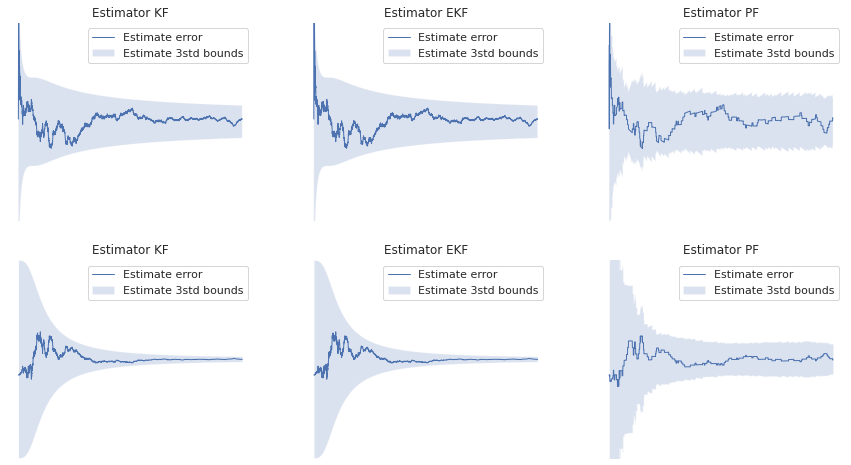

In [6]:
# Collect the estimators into a map
estimators = {"KF": kf, "EKF": ekf, "PF": pf}

# Generate a dataset with ground truth to benchmark the estimators on
nt = 4000
u = np.array([0.0011])
t = np.arange(0, nt, 1)
x = np.zeros((2, nt))
y = np.zeros((1, nt))
x[:, 0] = np.array([0, 4.8481e-7])
y[:, 0] = measurement.measurement(x[:, 0]).sample()
for k in range(nt - 1):
    x[:, k+1] = dynamics.dynamics(x[:, k], u).sample()
    y[:, k+1] = measurement.measurement(x[:, k+1]).sample()

# Plot the recorded states
f, ax = plt.subplots(2, 3, sharex=True, figsize=(15, 8))
sns.despine(f, left=True, bottom=True)

ylim = np.array([[1e-3, -1e-3], [3e-6, -3e-6]])
for j in range(len(list(estimators.keys()))):
    name = list(estimators.keys())[j]
    estimator = estimators[name]
    
    # Generate measurements, dynamics and estimated for nt steps
    belief = estimator.belief()
    bMu = np.zeros((2, nt))
    bVar = np.zeros((2, nt))
    bMu[:, 0] = belief.mean()
    bVar[:, 0] = belief.covariance().diagonal()
    
    # Simulate the estimator
    for k in range(nt):
        belief = estimator.estimate(y[:, k], u)
        bMu[:, k] = belief.mean()
        bVar[:, k] = belief.covariance().diagonal()
    
    for i in range(2):
        plt.sca(ax[i, j])
        ax[i, j].fill_between(t,
                              -3 * np.sqrt(bVar[i, :]),
                              +3 * np.sqrt(bVar[i, :]),
                              alpha=0.2, label="Estimate 3std bounds")
        ax[i, j].plot(t, x[i, :] - bMu[i, :], lw=1, label="Estimate error")
        ax[i, j].legend()
        ax[i, j].axis("off")
        plt.ylim(ylim[i, :])
        plt.ylabel("State " + str(i))
        plt.xlabel("Timestep k")
        plt.title("Estimator " + name)